In [56]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import datetime

In [57]:
dataset = h5py.File('simu_HDF.h5', 'r')
num_diodes = dataset['Num_diodes'][...]
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
output = np.vstack((x_pos,y_pos))
output = np.transpose(output)
where_are_NaNs = isnan(histgrid)
histgrid[where_are_NaNs] = 0

dataset.close()
#print(histgrid)
#print(output)

In [58]:
histgrid.shape

(342, 132, 1001)

In [59]:
histgrid[0,0:132,0]

array([  0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   7.,  24.,
        58.,  82.,  57.,  29.,   5.,   0.,   2.,   1.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   6.,
        71., 110.,  95.,   5.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   7.,  36.,
        47.,  61.,  71.,  20.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
         2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   7.,
        57., 124.,  54.,  10.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [60]:
#Testing lists vs arrays
all_data = []
labels = []
for i in range(343):
    all_data.append(i)
    labels.append(i)

In [159]:
def data_compile(histdata):
    data = []
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j])
            labels.append(output[i])
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)
all_data.reshape(-1,1)

[-12. -12.]


array([[0.00000000e+000],
       [0.00000000e+000],
       [1.00000000e+000],
       ...,
       [6.35192734e-269],
       [2.03268160e-068],
       [9.00829169e-312]])

In [107]:
all_data = normalize(all_data,axis = 1)
max_value = np.amax(all_data)
print(max_value)
#no need to normalize if max == 1 ??

1.0


In [108]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)

In [109]:
train_data.ndim

2

In [110]:
train_data.shape

(273600, 132)

In [111]:
train_data[0]

array([0.35320744, 0.25901879, 0.04709433, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00392453, 0.        , 0.        , 0.        ,
       0.00392453, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392453,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00784905, 0.12950939, 0.30218859, 0.23547163, 0.21192446,
       0.10988676, 0.01569811, 0.00392453, 0.        , 0.00784905,
       0.        , 0.        , 0.        , 0.00392453, 0.        ,
       0.        , 0.        , 0.        , 0.00392453, 0.00392453,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00392453, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00392453, 0.        , 0.        , 0.        , 0.        ,
       0.00392453, 0.        , 0.00392453, 0.00392453, 0.06279

In [112]:
log_dir = "logs/fit/" + "O-PPAC_FCNN" + "RMSprop0.001,mse,no_dropout,1dense128,relu"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [113]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [129]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [130]:
FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [187]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=50,
                    batch_size = 32,
                    callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/50
5985/5985 [==============================] - 18s 3ms/step - loss: 0.6892 - mae: 0.5582 - mse: 0.6892 - val_loss: 0.7698 - val_mae: 0.5665 - val_mse: 0.7698
Epoch 2/50
5985/5985 [==============================] - 17s 3ms/step - loss: 0.6638 - mae: 0.5466 - mse: 0.6638 - val_loss: 0.7001 - val_mae: 0.5515 - val_mse: 0.7001
Epoch 3/50
5985/5985 [==============================] - 17s 3ms/step - loss: 0.6327 - mae: 0.5331 - mse: 0.6327 - val_loss: 0.6303 - val_mae: 0.5117 - val_mse: 0.6303
Epoch 4/50
5985/5985 [==============================] - 18s 3ms/step - loss: 0.6092 - mae: 0.5220 - mse: 0.6092 - val_loss: 0.7461 - val_mae: 0.5574 - val_mse: 0.7461
Epoch 5/50
5985/5985 [==============================] - 17s 3ms/step - loss: 0.5877 - mae: 0.5113 - mse: 0.5877 - val_loss: 0.6387 - val_mae: 0.5174 - val_mse: 0.6387
Epoch 6/50
5985/5985 [==============================] - 18s 3ms/step - loss: 0.5664 - mae: 0.5016 - mse: 0.5664 - val_loss: 0.5558 - val_mae: 0.4701 - val_mse: 0.555

Epoch 50/50
5985/5985 [==============================] - 19s 3ms/step - loss: 0.2740 - mae: 0.3344 - mse: 0.2740 - val_loss: 0.4056 - val_mae: 0.3752 - val_mse: 0.4056


Text(0.5, 1.0, 'FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation')

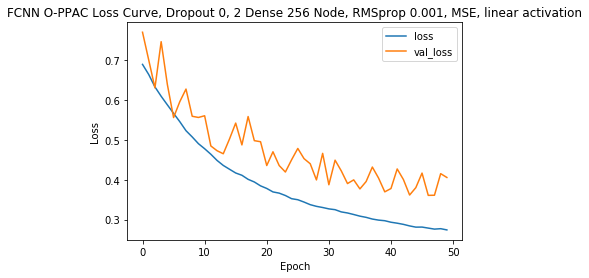

In [188]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 40])
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

In [189]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2138/2138 - 3s - loss: 0.3643 - mae: 0.3761 - mse: 0.3643


In [190]:
predictions = FCNN_model.predict(test_data)

In [191]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]

print(type(x_pred))
print(type(x_test))

x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [192]:
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

[24.0]

Text(0.5, 1.0, 'FCNN O-PPAC X Predictions vs True X Values')

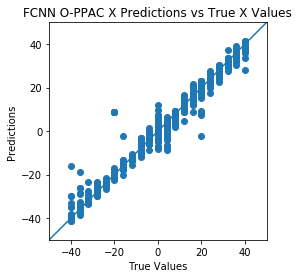

In [193]:
a = plt.axes(aspect='equal')
plt.scatter(new_x_labels, x_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC X Predictions vs True X Values")

In [194]:
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

[-20.0]

Text(0.5, 1.0, 'FCNN O-PPAC Y Predictions vs True Y Values')

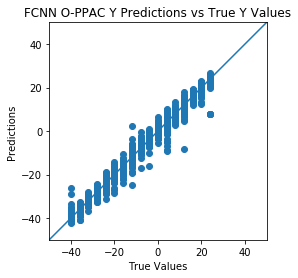

In [195]:
a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")